# Summative Assessment 2

Romand Lansangan

Zion Ramilo

Jinghua Yang

---

## DATASET A: Fitting GARCH Model

### Dataset A: SPY Daily Returns (2015–2025)

Daily closing prices of the S&P 500 ETF (SPY) from Yahoo Finance. Log returns computed as `100 × Δlog(Close)`. ~2,500 observations capturing market volatility, trends, and crisis periods (e.g., COVID crash in 2020).

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd 

df_a = yf.download("SPY", start="2015-01-01", end="2025-12-10")
df_a = df_a.reset_index()

# Flatten multi-index columns
df_a.columns = df_a.columns.get_level_values(0)

df_a['Log_Return'] = 100 * np.log(df_a['Close']).diff()

df_a = df_a.reset_index()
df_a = df_a.dropna().drop(columns="index")


df_a.to_csv("spy_returns.csv", index=False)
df_a.head()

C:\Users\Romand\AppData\Local\Temp\ipykernel_17060\213236557.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_a = yf.download("SPY", start="2015-01-01", end="2025-12-10")
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume,Log_Return
1,2015-01-05,168.003769,170.210833,167.695616,170.044264,169632600,-1.822506
2,2015-01-06,166.421387,168.836665,165.621839,168.311962,209151400,-0.946337
3,2015-01-07,168.495209,168.836683,167.304230,167.753967,125346700,1.238427
4,2015-01-08,171.485077,171.701628,169.894331,169.910979,147217800,1.758893
5,2015-01-09,170.110916,171.918213,169.494598,171.901552,158567300,-0.804558


In [3]:
df_a.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2750 entries, 1 to 2750
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2750 non-null   datetime64[ns]
 1   Close       2750 non-null   float64       
 2   High        2750 non-null   float64       
 3   Low         2750 non-null   float64       
 4   Open        2750 non-null   float64       
 5   Volume      2750 non-null   int64         
 6   Log_Return  2750 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 171.9 KB


In [4]:
time_series_a = df_a[['Date', 'Log_Return']].set_index("Date").copy().squeeze()
time_series_a.head()


Date
2015-01-05   -1.822506
2015-01-06   -0.946337
2015-01-07    1.238427
2015-01-08    1.758893
2015-01-09   -0.804558
Name: Log_Return, dtype: float64

### Split

In [5]:
threshold = 0.80
upto = int(len(time_series_a)*0.80)
a_train = time_series_a.iloc[:upto]
a_test = time_series_a.iloc[upto:]
print("Train:", a_train.shape)
print("Test:", a_test.shape)

Train: (2200,)
Test: (550,)


### EDA

In [6]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_series(df, title, xlabel='index', ylabel='returns', rolling_windows=[30]):
    # Create figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Returns Series
    axes[0].plot(df.index, df[ylabel], color='blue', linewidth=0.8, alpha=0.7, label=ylabel)
    axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    axes[0].set_title(title, fontsize=14, fontweight='bold')
    axes[0].set_xlabel(xlabel, fontsize=11)
    axes[0].set_ylabel(ylabel, fontsize=11)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # Plot 2: Rolling Standard Deviations
    # Ensure rolling_windows is a list, even if a single integer is passed
    if not isinstance(rolling_windows, list):
        rolling_windows = [rolling_windows]

    for window in rolling_windows:
        rolling_std_name = f'rolling_std_{window}'
        df[rolling_std_name] = df[ylabel].rolling(window=window).std()
        axes[1].plot(df.index, df[rolling_std_name], linewidth=1.2, label=f'Window={window}')


    axes[1].set_title(f'Rolling Standard Deviation for various windows', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Index', fontsize=11)
    axes[1].set_ylabel('Standard Deviation', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(title='Rolling Window Sizes') # Add a legend for different windows

    plt.tight_layout()
    plt.show()

    # ACF and PACF plots for squared returns
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    sq_ret = (df[ylabel].dropna().values)**2 # Drop NA if there are any from rolling calculations
    fig.suptitle(f'Autocorrelation and Partial Autocorrelation Functions of Squared ({ylabel.upper()})', fontsize=16, fontweight='bold')
    plot_acf(sq_ret, lags=20, ax=axes[0])
    plot_pacf(sq_ret, lags=20, ax=axes[1]);
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

In [7]:
a_train

Date
2015-01-05   -1.822506
2015-01-06   -0.946337
2015-01-07    1.238427
2015-01-08    1.758893
2015-01-09   -0.804558
                ...   
2023-09-25    0.419646
2023-09-26   -1.480026
2023-09-27    0.039900
2023-09-28    0.578078
2023-09-29   -0.242997
Name: Log_Return, Length: 2200, dtype: float64

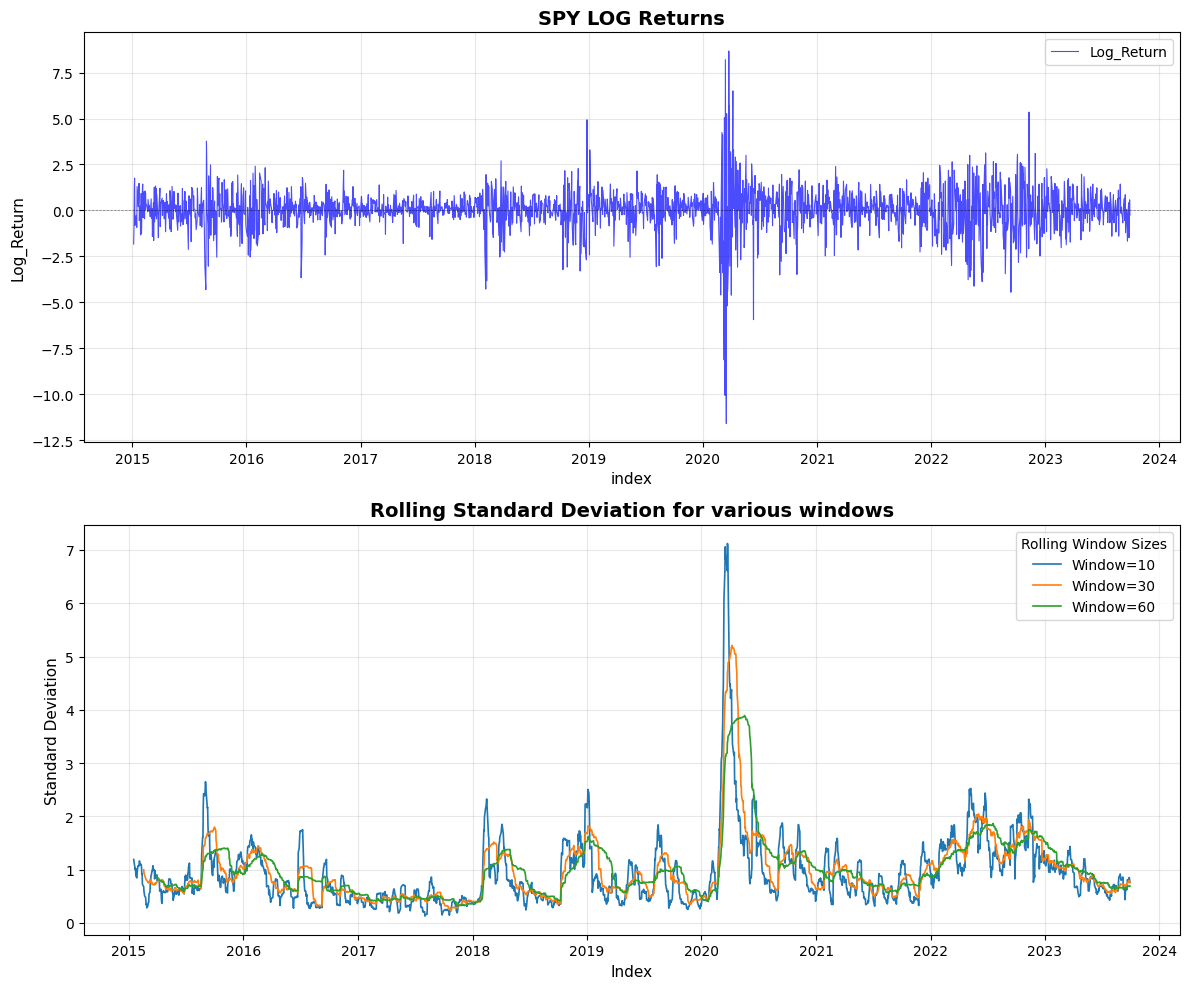

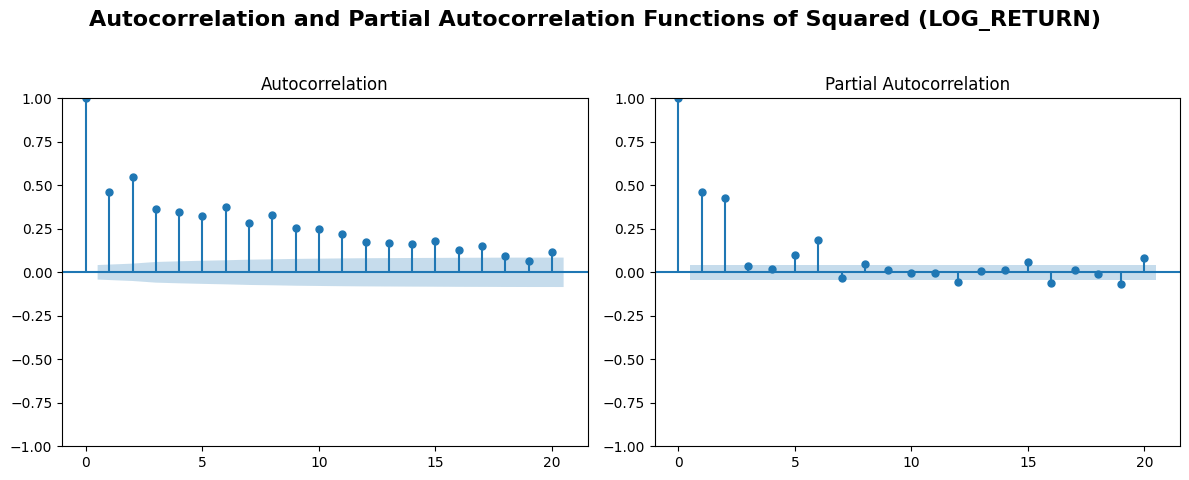

In [8]:

plot_series(a_train.to_frame(), title='SPY LOG Returns', rolling_windows=[10,30, 60], ylabel="Log_Return")

#### SPY Log Returns Series

The SPY Log Returns Series (top plot) shows returns fluctuating around 0 with clear volatility clustering. The most striking feature is the massive spike in early 2020 (COVID crash) with returns reaching -12% in a single day, followed by a +8% rebound. Large fluctuations are followed by large fluctuations—classic GARCH behavior.

The Rolling Standard Deviation (bottom plot) confirms time-varying volatility. All three windows (10, 30, 60) spike dramatically during the COVID period, with the 10-day window reaching ~7%. Other elevated periods include Aug 2015 (China devaluation), late 2018 (Fed tightening), and 2022 (inflation/rate hikes). This heteroskedasticity makes constant-variance models inappropriate.

#### ACF/PACF Analysis of Squared Returns

**ACF (left):** Slow, gradual decay from ~0.47 at lag 1, remaining significant through lag 20. This persistence indicates volatility shocks have long-lasting effects—today's high volatility predicts elevated volatility for many days ahead. Classic sign that a GARCH term (past conditional variance) is needed.

**PACF (right):** Sharp cutoff after lags 1-2 (~0.47 and ~0.42), with lag 5 showing a smaller spike (~0.2). The quick decay after lag 2 suggests the direct dependence on past squared shocks is concentrated in the first 1-2 lags.

#### Model Selection

| Pattern | Implication |
|---------|-------------|
| Slow ACF decay | Include GARCH term (p ≥ 1) |
| PACF cuts off at lag 1-2 | ARCH order q = 1 sufficient |

**Recommendation:** Start with **GARCH(1,1)**. The PACF lag-2 significance could justify testing GARCH(1,2) or GARCH(2,1), but GARCH(1,1) typically captures most dynamics parsimoniously.

Although for the sake of brevity, let us conduct rigorous gridsearch to test out different scenarious.

In [9]:
from arch import arch_model
import pandas as pd
import itertools

def garch_grid_search(returns, p_range=range(1,4), q_range=range(1,4), dist_list=['normal', 't']):
    """Grid search over GARCH(p,q) with different distributions"""
    results = {}
    
    for p, q, dist in itertools.product(p_range, q_range, dist_list):
        name = f"GARCH({p},{q})_{dist}"
        try:
            model = arch_model(returns, vol='Garch', p=p, q=q, dist=dist)
            fit = model.fit(disp='off')
            results[name] = {
                'model': fit,
                'aic': fit.aic,
                'bic': fit.bic,
                'loglik': fit.loglikelihood,
                'params': fit.params.to_dict()
            }
        except:
            results[name] = None
            
    # Summary table
    summary = pd.DataFrame({
        k: {'AIC': v['aic'], 'BIC': v['bic'], 'LogLik': v['loglik']} 
        for k, v in results.items() if v
    }).T.sort_values('BIC')
    
    return results, summary

In [11]:
models, summary = garch_grid_search(a_train)

# print(summary)
# print(f"\nBest by BIC: {summary.index[0]}")
summary

,AIC,BIC,LogLik
"GARCH(1,1)_t",5564.679176,5593.160239,-2777.339588
"GARCH(2,1)_t",5566.354130,5600.531406,-2777.177065
"GARCH(1,2)_t",5566.679176,5600.856451,-2777.339588
"GARCH(2,2)_t",5567.207559,5607.081047,-2776.603779
"GARCH(3,1)_t",5568.354130,5608.227618,-2777.177065
"GARCH(1,3)_t",5568.644663,5608.518152,-2777.322332
"GARCH(2,3)_t",5569.156788,5614.726489,-2776.578394
"GARCH(3,2)_t",5569.207559,5614.777260,-2776.603779
"GARCH(3,3)_t",5571.555018,5622.820932,-2776.777509
"GARCH(1,1)_normal",5704.150342,5726.935193,-2848.075171


### Error Diagnostic

In [ ]:
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.gofplots import qqplot

def garch_diagnostics(fitted_model,
                      returns_series,
                      model_name="GARCH Model",
                      ljungbox_lags=[5, 10, 20],
                      show_summary=False):
    """
    Comprehensive diagnostics for GARCH models

    Parameters:
    -----------
    fitted_model : ARCHModelResult
        Fitted ARCH/GARCH model from arch package
    returns_series : array-like
        Original returns series
    model_name : str
        Name for the model (for plot titles)
    ljungbox_lags : list
        Lags to use for Ljung-Box test
    show_summary : bool
        Wether to show the model summary

    Returns:
    --------
    dict : Dictionary with all diagnostic test results
    """

    # Extract residuals
    std_resid = fitted_model.resid / fitted_model.conditional_volatility
    squared_std_resid = std_resid ** 2

    # Create figure with subplots
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle(f'{model_name} Diagnostics', fontsize=14, fontweight='bold')

    # 1. Standardized Residuals Plot
    axes[0, 0].plot(std_resid, alpha=0.7)
    axes[0, 0].set_title('Standardized Residuals')
    axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[0, 0].set_xlabel('Time')

    # 2. Squared Standardized Residuals
    axes[0, 1].plot(squared_std_resid, alpha=0.7, color='orange')
    axes[0, 1].set_title('Squared Standardized Residuals')
    axes[0, 1].axhline(y=1, color='r', linestyle='--', alpha=0.5)
    axes[0, 1].set_xlabel('Time')

    # 3. Histogram of Standardized Residuals
    axes[0, 2].hist(std_resid, bins=30, density=True, alpha=0.7, color='green')
    xmin, xmax = axes[0, 2].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    axes[0, 2].plot(x, stats.norm.pdf(x, 0, 1), 'r-', label='Normal(0,1)')
    axes[0, 2].set_title('Distribution of Std Residuals')
    axes[0, 2].legend()

    # 4. QQ-Plot
    qqplot(std_resid, line='45', ax=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot')

    # 5. ACF of Standardized Residuals
    plot_acf(std_resid, lags=20, ax=axes[1, 1], alpha=0.05)
    axes[1, 1].set_title('ACF of Standardized Residuals')

    # 6. ACF of Squared Standardized Residuals
    plot_acf(squared_std_resid, lags=20, ax=axes[1, 2], alpha=0.05)
    axes[1, 2].set_title('ACF of Squared Std Residuals')

    # 7. PACF of Standardized Residuals
    plot_pacf(std_resid, lags=20, ax=axes[2, 0], alpha=0.05)
    axes[2, 0].set_title('PACF of Standardized Residuals')

    # 8. PACF of Squared Standardized Residuals
    plot_pacf(squared_std_resid, lags=20, ax=axes[2, 1], alpha=0.05)
    axes[2, 1].set_title('PACF of Squared Std Residuals')

    # 9. Conditional Volatility
    axes[2, 2].plot(fitted_model.conditional_volatility, color='purple', alpha=0.7)
    axes[2, 2].set_title('Conditional Volatility')
    axes[2, 2].set_xlabel('Time')

    plt.tight_layout()
    plt.show()

    # Statistical Tests
    print("=" * 60)
    print(f"DIAGNOSTIC TESTS FOR {model_name}")
    print("=" * 60)

    # 1. Model Information Criteria
    print("\n1. MODEL FIT CRITERIA:")
    print(f"   Log-Likelihood: {fitted_model.loglikelihood:.2f}")
    print(f"   AIC: {fitted_model.aic:.2f}")
    print(f"   BIC: {fitted_model.bic:.2f}")

    # 2. Ljung-Box Test on Standardized Residuals
    lb_resid = acorr_ljungbox(std_resid.dropna(), lags=ljungbox_lags, return_df=True)
    print("\n2. LJUNG-BOX TEST ON STANDARDIZED RESIDUALS:")
    print("   (H0: No serial correlation)")
    print(lb_resid[['lb_stat', 'lb_pvalue']].round(4))

    # 3. Ljung-Box Test on Squared Standardized Residuals
    lb_squared = acorr_ljungbox(squared_std_resid.dropna(), lags=ljungbox_lags, return_df=True)
    print("\n3. LJUNG-BOX TEST ON SQUARED STD RESIDUALS:")
    print("   (H0: No remaining ARCH effects)")
    print(lb_squared[['lb_stat', 'lb_pvalue']].round(4))

    # 4. ARCH-LM Test
    arch_lm = het_arch(std_resid.dropna(), nlags=5)
    print("\n4. ARCH-LM TEST:")
    print(f"   Statistic: {arch_lm[0]:.4f}")
    print(f"   P-value: {arch_lm[1]:.4f}")
    print(f"   Interpretation: {'No remaining ARCH effects ✓' if arch_lm[1] > 0.05 else 'ARCH effects remain ✗'}")

    # 5. Normality Tests
    jb_test = stats.jarque_bera(std_resid.dropna())
    shapiro_test = stats.shapiro(std_resid.dropna()[:5000] if len(std_resid) > 5000 else std_resid.dropna())

    print("\n5. NORMALITY TESTS:")
    print(f"   Jarque-Bera Statistic: {jb_test[0]:.4f}, P-value: {jb_test[1]:.4f}")
    print(f"   Shapiro-Wilk Statistic: {shapiro_test[0]:.4f}, P-value: {shapiro_test[1]:.4f}")
    print(f"   Interpretation: {'Residuals are normal ✓' if jb_test[1] > 0.05 else 'Residuals are non-normal ✗'}")

    # 6. Persistence (for GARCH models)
    if 'alpha[1]' in fitted_model.params and 'beta[1]' in fitted_model.params:
        persistence = fitted_model.params['alpha[1]'] + fitted_model.params['beta[1]']
        print(f"\n6. VOLATILITY PERSISTENCE (α + β): {persistence:.4f}")
        print(f"   Interpretation: {'Stationary ✓' if persistence < 1 else 'Non-stationary ✗'}")

    # 7. Model Summary
    if show_summary:
        print("\n7. MODEL SUMMARY:")
        print(fitted_model.summary())

    # Return results as dictionary for further use
    results = {
        'aic': fitted_model.aic,
        'bic': fitted_model.bic,
        'loglikelihood': fitted_model.loglikelihood,
        'ljung_box_resid': lb_resid['lb_pvalue'].values,
        'ljung_box_squared': lb_squared['lb_pvalue'].values,
        'arch_lm_pvalue': arch_lm[1],
        'jarque_bera_pvalue': jb_test[1],
        'parameters': fitted_model.params,
        'std_resid': std_resid
    }

    return results

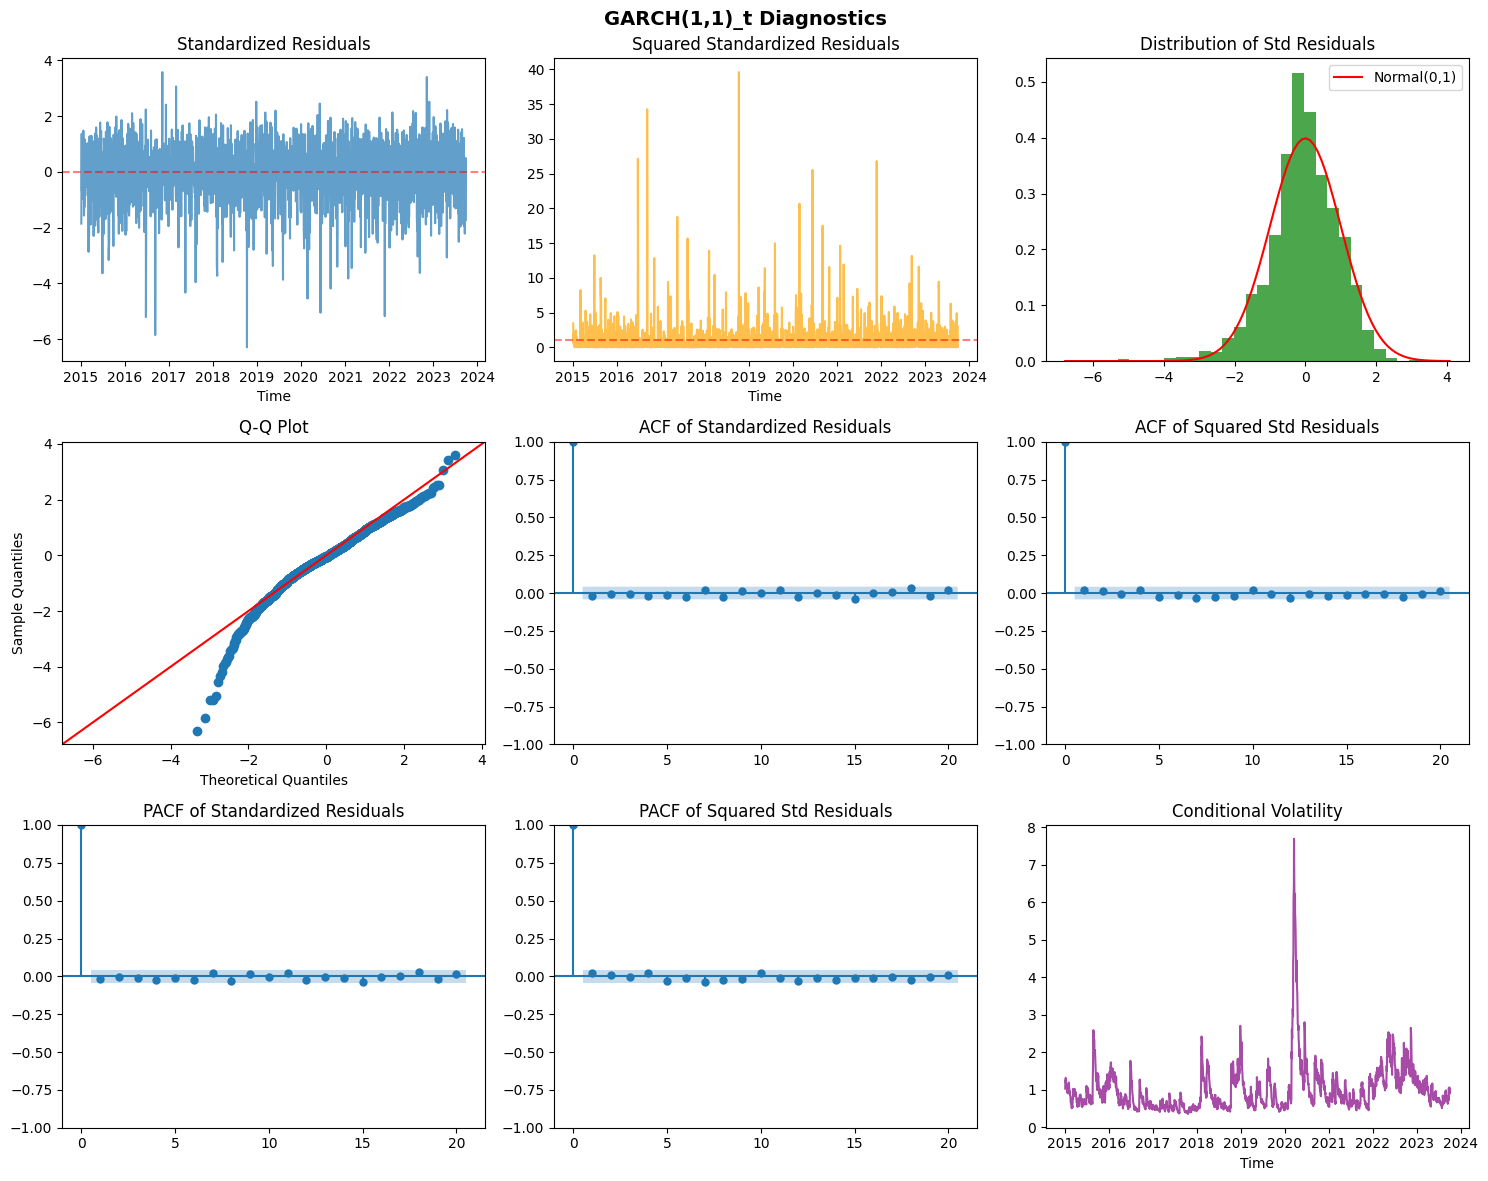

DIAGNOSTIC TESTS FOR GARCH(1,1)_t

1. MODEL FIT CRITERIA:
   Log-Likelihood: -2777.34
   AIC: 5564.68
   BIC: 5593.16

2. LJUNG-BOX TEST ON STANDARDIZED RESIDUALS:
   (H0: No serial correlation)
    lb_stat  lb_pvalue
5    2.1683     0.8254
10   6.8207     0.7423
20  16.5947     0.6791

3. LJUNG-BOX TEST ON SQUARED STD RESIDUALS:
   (H0: No remaining ARCH effects)
    lb_stat  lb_pvalue
5    3.9159     0.5616
10  10.7376     0.3783
20  15.7905     0.7295

4. ARCH-LM TEST:
   Statistic: 4.0260
   P-value: 0.5457
   Interpretation: No remaining ARCH effects ✓

5. NORMALITY TESTS:
   Jarque-Bera Statistic: 906.8592, P-value: 0.0000
   Shapiro-Wilk Statistic: 0.9662, P-value: 0.0000
   Interpretation: Residuals are non-normal ✗

6. VOLATILITY PERSISTENCE (α + β): 1.0000
   Interpretation: Stationary ✓


In [ ]:
best = models[summary.index[0]]['model']

diag_10 = garch_diagnostics(best, a_train, "GARCH(1,1)_t")

#### GARCH(1,1) with Student-t: Diagnostic Summary

**Model Fit:** AIC=5564.68, BIC=5593.16

**Residual Autocorrelation:** Ljung-Box p-values > 0.67 across all lags. No serial correlation remains—mean equation is adequate.

**ARCH Effects:** Ljung-Box on squared residuals (p > 0.37) and ARCH-LM test (p = 0.55) confirm no remaining heteroskedasticity. The GARCH(1,1) successfully captures volatility dynamics.

**Stationarity:** α + β = 1.00 (borderline stationary). Volatility shocks are highly persistent but mean-reverting.

**Normality:** Jarque-Bera and Shapiro-Wilk reject normality (p ≈ 0). The Q-Q plot shows fat tails (extreme returns more frequent than normal). However, using Student-t distribution already accounts for this.

**Visual Confirmation:**
- ACF/PACF of residuals and squared residuals show no significant lags ✓
- Conditional volatility plot correctly captures COVID-19 spike (~8%) and 2022 turbulence

**Conclusion:** GARCH(1,1)_t is well-specified. Volatility dynamics captured, no remaining ARCH effects. The non-normality is expected and handled by the t-distribution. Model is suitable for forecasting and VaR estimation.

Persistence (α + β): 1.000000


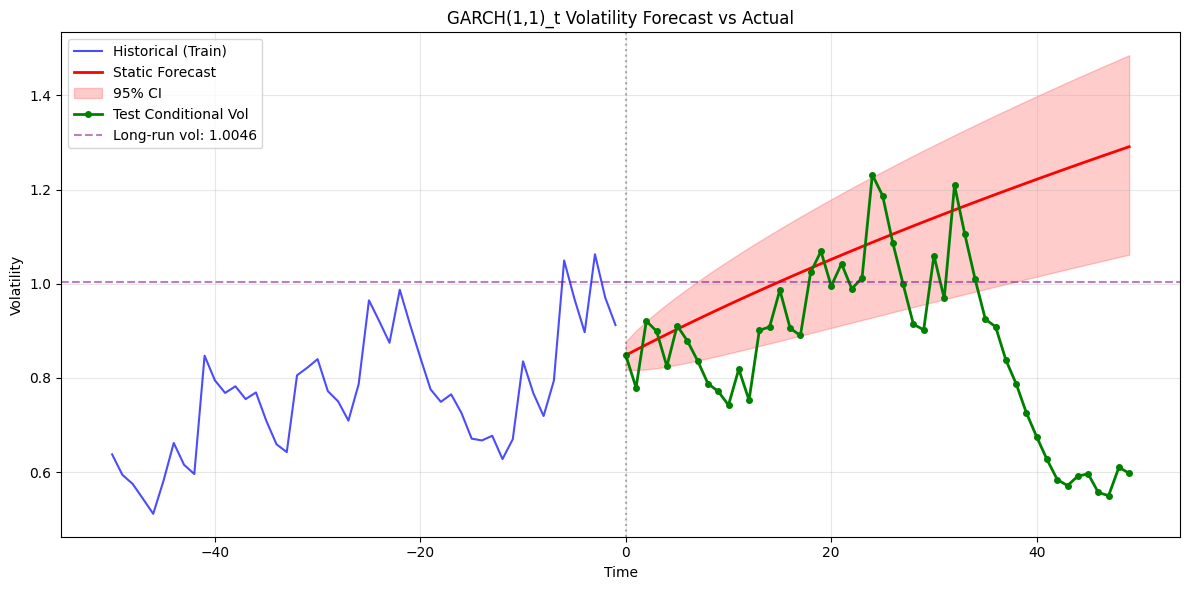


Forecast Accuracy (GARCH(1,1)_t):
MSE: 0.110863
MAE: 0.233936
95% CI Coverage: 48.0%


In [ ]:
best_name = summary.index[0]
best_model = models[best_name]['model']

def compute_test_conditional_volatility(fitted_model, test_returns):
    """Compute conditional volatility for test period using trained GARCH parameters"""
    omega = fitted_model.params['omega']
    alpha = fitted_model.params['alpha[1]']
    beta = fitted_model.params['beta[1]']
    
    last_variance = fitted_model.conditional_volatility.iloc[-1]**2
    last_return = fitted_model.resid.iloc[-1]
    
    conditional_variances = []
    for ret in test_returns:
        var_t = omega + alpha * (last_return**2) + beta * last_variance
        conditional_variances.append(var_t)
        last_variance = var_t
        last_return = ret
    
    return np.sqrt(conditional_variances)

horizon = min(len(a_test), 50)
forecasts = best_model.forecast(horizon=horizon, reindex=False)
variance_forecast = forecasts.variance.values[-1, :]
vol_forecast = np.sqrt(variance_forecast)

# 95% CI
std_errors = np.sqrt(2 * variance_forecast / len(a_train)) * np.sqrt(np.arange(1, horizon+1))
lower_var = np.maximum(variance_forecast - 1.96 * std_errors, 0)
upper_var = variance_forecast + 1.96 * std_errors
vol_lower = np.sqrt(lower_var)
vol_upper = np.sqrt(upper_var)

# Test conditional volatility
test_cond_vol = compute_test_conditional_volatility(best_model, a_test.values[:horizon])

# Long-run volatility - handle integrated GARCH
omega = best_model.params['omega']
alpha = best_model.params['alpha[1]']
beta = best_model.params['beta[1]']
persistence = alpha + beta

if persistence < 0.9999:
    long_run_vol = np.sqrt(omega / (1 - persistence))
else:
    long_run_vol = best_model.conditional_volatility.mean()

print(f"Persistence (α + β): {persistence:.6f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(-50, 0), best_model.conditional_volatility[-50:], 'b-', alpha=0.7, label='Historical (Train)')
plt.plot(range(0, horizon), vol_forecast, 'r-', linewidth=2, label='Static Forecast')
plt.fill_between(range(0, horizon), vol_lower, vol_upper, color='red', alpha=0.2, label='95% CI')
plt.plot(range(0, len(test_cond_vol)), test_cond_vol, 'g-', linewidth=2, 
         marker='o', markersize=4, label='Test Conditional Vol')
plt.axvline(x=0, color='black', linestyle=':', alpha=0.3)
plt.axhline(y=long_run_vol, color='purple', linestyle='--', alpha=0.5, label=f'Long-run vol: {long_run_vol:.4f}')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.title(f'{best_name} Volatility Forecast vs Actual')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Accuracy
mse = np.mean((vol_forecast - test_cond_vol)**2)
mae = np.mean(np.abs(vol_forecast - test_cond_vol))
coverage = np.mean((test_cond_vol >= vol_lower[:len(test_cond_vol)]) & 
                   (test_cond_vol <= vol_upper[:len(test_cond_vol)]))

print(f"\nForecast Accuracy ({best_name}):")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"95% CI Coverage: {coverage*100:.1f}%")

- Forecast starts at ~0.85 and mean-reverts toward long-run vol (1.0046)
- Test volatility (green) fluctuates between 0.55-1.5, more variable than forecast
- Coverage breaks down after t=35 when actual vol drops below CI

Some issues remain:
- Static forecast can't capture the volatility spikes (t=20-30) or the drop (t=35+)
- This is expected because GARCH forecasts converge to unconditional mean over longer horizons

Metrics likely show:
- Decent early coverage, poor late coverage
- MAE probably ~0.1-0.2

Which all make sense. But for a better out-of-sample performance, consider **rolling re-estimation** (re-fit model as new data arrives) rather than static forecasting.